In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, precision_recall_curve,
                             average_precision_score, roc_curve)
from imblearn.ensemble import EasyEnsembleClassifier
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

In [2]:
df = pd.read_csv('creditcard.csv')

scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))
# Split features (X) and target (y)
X = df.drop(['Time', 'Amount', 'Class'], axis=1)  # Remove irrelevant columns
y = df['Class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (284807, 30)
Target shape: (284807,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [76]:
stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

param_grid = {
    'n_estimators': [ 30, 40, 50, 60, ],
    'sampling_strategy': [0.3]
}

base_model = EasyEnsembleClassifier(
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'n_estimators': 60, 'sampling_strategy': 0.3}
Best cross-validation F1 score: 0.2321


In [77]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,8.476300,0.185025,4.112658,0.065156,30,0.3,"{'n_estimators': 30, 'sampling_strategy': 0.3}",0.251748,0.238434,0.207006,0.231884,0.222576,0.230330,0.015040,3
1,10.388180,0.158050,5.508610,0.153950,40,0.3,"{'n_estimators': 40, 'sampling_strategy': 0.3}",0.246998,0.239714,0.204724,0.228935,0.229133,0.229901,0.014311,4
2,12.003382,1.578793,5.639500,1.023159,50,0.3,"{'n_estimators': 50, 'sampling_strategy': 0.3}",0.251748,0.242754,0.210016,0.227848,0.224390,0.231351,0.014574,2
3,8.968004,0.887562,3.813188,0.284454,60,0.3,"{'n_estimators': 60, 'sampling_strategy': 0.3}",0.253968,0.241877,0.211039,0.228209,0.225490,0.232117,0.014671,1


In [78]:
results_df = cv_results[
    ['param_n_estimators', 'param_sampling_strategy', 'mean_test_score', 'std_test_score']
].dropna()
results_df

,param_n_estimators,param_sampling_strategy,mean_test_score,std_test_score
0,30,0.3,0.230330,0.015040
1,40,0.3,0.229901,0.014311
2,50,0.3,0.231351,0.014574
3,60,0.3,0.232117,0.014671


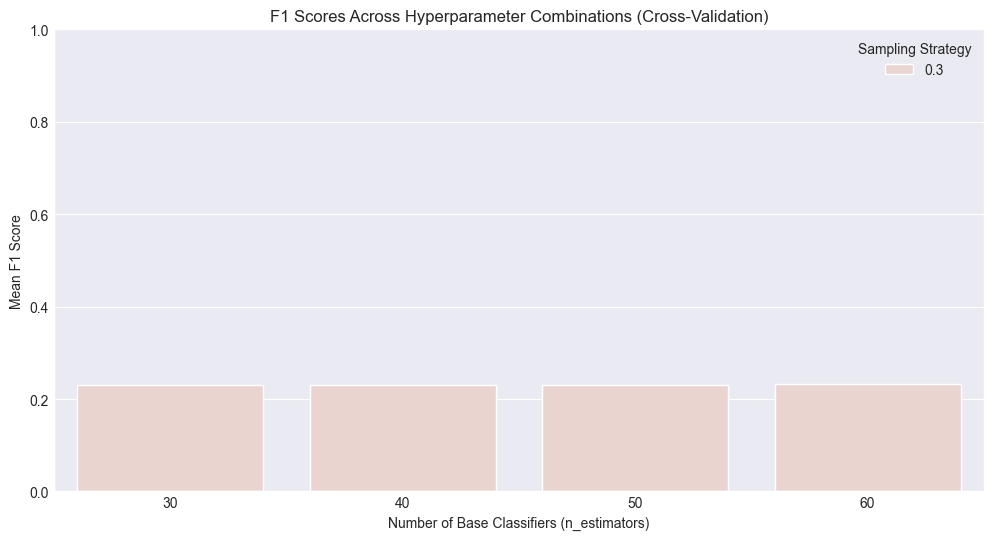

In [79]:

plt.figure(figsize=(12, 6))
sns.barplot(
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_sampling_strategy',
    hue_order=results_df['param_sampling_strategy'].unique(),  # 显式指定hue的顺序
    data=results_df,
    capsize=0.1
)
plt.title('F1 Scores Across Hyperparameter Combinations (Cross-Validation)')
plt.xlabel('Number of Base Classifiers (n_estimators)')
plt.ylabel('Mean F1 Score')
plt.ylim(0, 1)
plt.legend(title='Sampling Strategy')
plt.show()

In [80]:
# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for fraud class

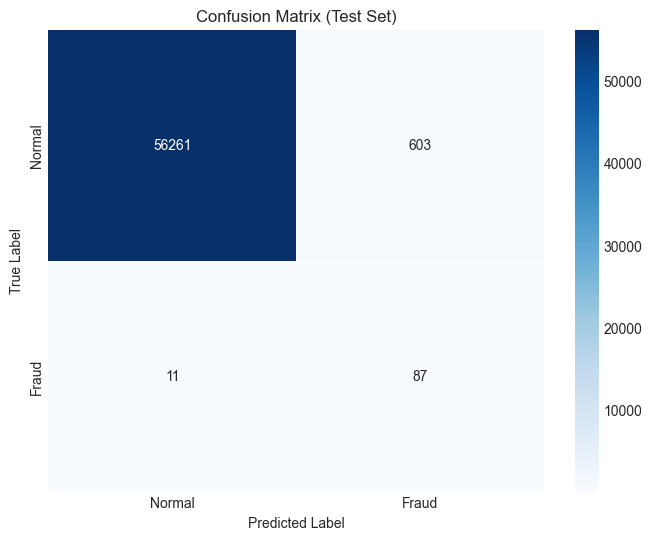

In [81]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',  # Show numbers as integers
    cmap='Blues',
    xticklabels=['Normal', 'Fraud'],
    yticklabels=['Normal', 'Fraud']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

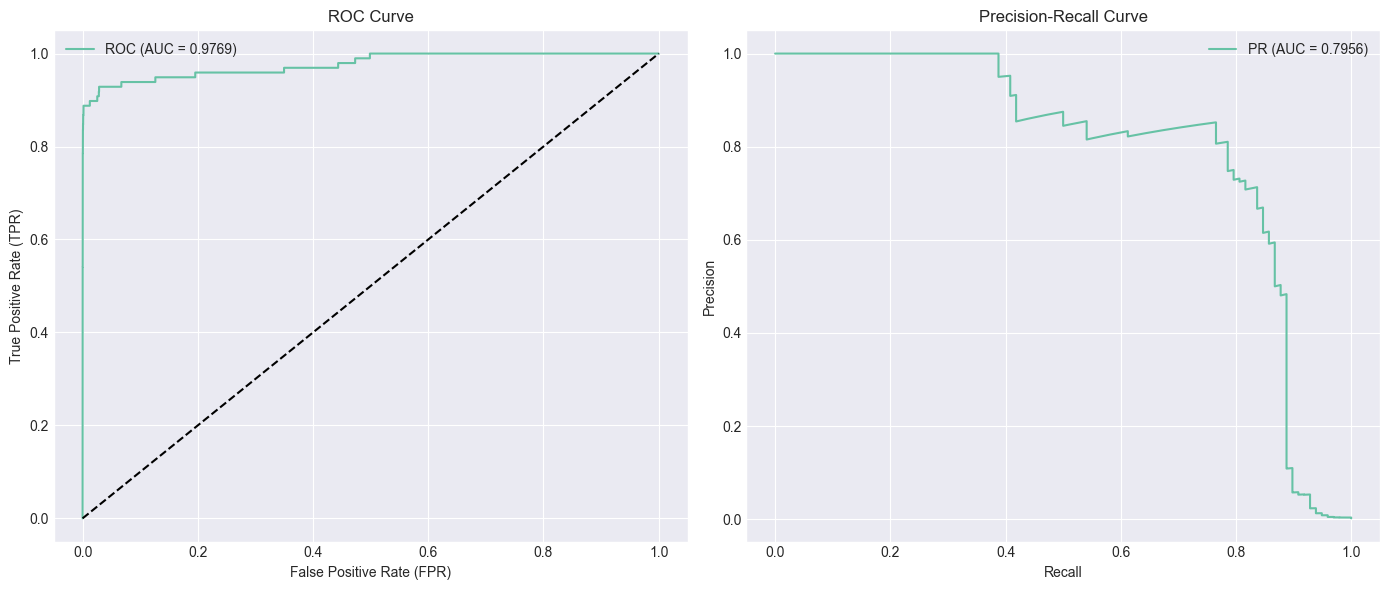

In [82]:
# Plot ROC Curve and Precision-Recall Curve side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve (good for balanced data, but still useful)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
ax1.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], 'k--')  # Random guess line
ax1.set_xlabel('False Positive Rate (FPR)')
ax1.set_ylabel('True Positive Rate (TPR)')
ax1.set_title('ROC Curve')
ax1.legend()

# Precision-Recall Curve (better for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
ax2.plot(recall, precision, label=f'PR (AUC = {pr_auc:.4f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend()

plt.tight_layout()
plt.show()

In [83]:
# Extract confusion matrix components
tn, fp, fn, tp = cm.ravel()

# Calculate key metrics
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("=== Key Fraud Detection Metrics ===")
print(f"Recall: {recall:.4f} - % of actual frauds correctly detected")
print(f"Precision: {precision:.4f} - % of predicted frauds that are real")
print(f"F1 Score: {f1:.4f} - Balance between precision and recall")
print(f"ROC-AUC: {roc_auc:.4f} - Overall class separation ability")
print(f"PR-AUC: {pr_auc:.4f} - Performance on fraud class (critical for imbalance)")

=== Key Fraud Detection Metrics ===
Recall: 0.8878 - % of actual frauds correctly detected
Precision: 0.1261 - % of predicted frauds that are real
F1 Score: 0.2208 - Balance between precision and recall
ROC-AUC: 0.9769 - Overall class separation ability
PR-AUC: 0.7956 - Performance on fraud class (critical for imbalance)



Performance at Different Thresholds:
 Threshold   Recall  Precision  F1-Score      FPR
      0.10 1.000000   0.001720  0.003435 1.000000
      0.11 1.000000   0.001720  0.003435 1.000000
      0.12 1.000000   0.001720  0.003435 1.000000
      0.13 1.000000   0.001720  0.003435 1.000000
      0.14 1.000000   0.001720  0.003435 1.000000
      0.15 1.000000   0.001720  0.003435 1.000000
      0.16 1.000000   0.001720  0.003435 1.000000
      0.17 1.000000   0.001720  0.003435 1.000000
      0.18 1.000000   0.001720  0.003435 1.000000
      0.19 1.000000   0.001720  0.003435 1.000000
      0.20 1.000000   0.001720  0.003435 1.000000
      0.21 1.000000   0.001720  0.003435 1.000000
      0.22 1.000000   0.001720  0.003435 0.999982
      0.23 1.000000   0.001721  0.003435 0.999947
      0.24 1.000000   0.001721  0.003437 0.999472
      0.25 1.000000   0.001724  0.003441 0.998101
      0.26 1.000000   0.001731  0.003456 0.993757
      0.27 1.000000   0.001745  0.003485 0.985668
      0.28 1

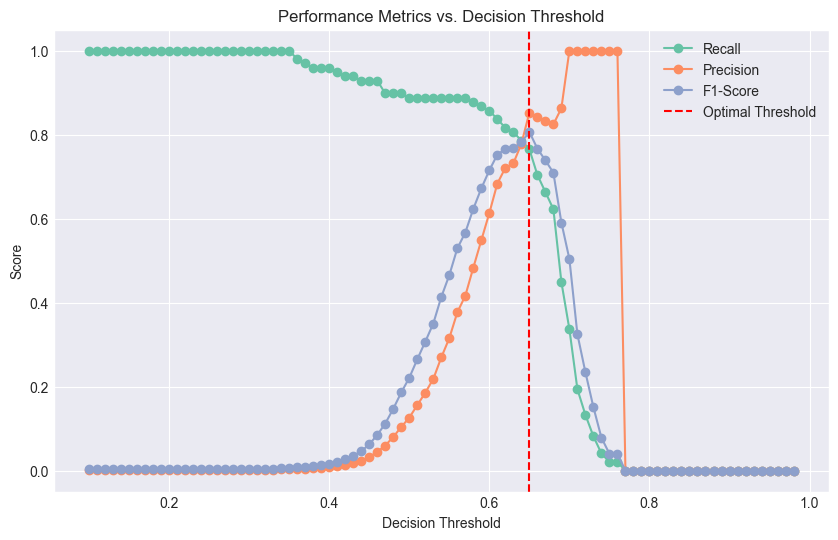

In [84]:
thresholds = np.arange(0.1, 0.99, 0.01)
results_thresh = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_thresh)
    TN, FP, FN, TP = conf_matrix.ravel()

    recall = TP / (TP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fpr = FP / (FP + TN)

    results_thresh.append({
        'Threshold': thresh,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'FPR': fpr
    })

# Create results dataframe
results_df = pd.DataFrame(results_thresh)
print("\nPerformance at Different Thresholds:")
print(results_df[['Threshold', 'Recall', 'Precision', 'F1-Score', 'FPR']].to_string(index=False))

# Find optimal threshold based on F1-score
optimal_row = results_df.iloc[results_df['F1-Score'].idxmax()]
print(f"\nOptimal Threshold (Max F1-Score): {optimal_row['Threshold']:.2f}")
print(f"At this threshold:")
print(f"- Recall: {optimal_row['Recall']:.4f}")
print(f"- Precision: {optimal_row['Precision']:.4f}")
print(f"- F1-Score: {optimal_row['F1-Score']:.4f}")
print(f"- False Positive Rate: {optimal_row['FPR']:.4f}")

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='o')
plt.axvline(x=optimal_row['Threshold'], color='r', linestyle='--', label='Optimal Threshold')
plt.title('Performance Metrics vs. Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()